In [414]:
using Plots; gr()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
using JLD2
# data_home = "../data/experiment_2/Experiment2"
# data_home = "../Experiment2_ESarsa_NoExploration"
data_home = "../Experiment2_NoExploringStarts"

"../Experiment2_NoExploringStarts"

In [510]:
include("./plot_utils.jl")
GPU = GeneralPlotUtils

Main.GeneralPlotUtils

In [511]:
# experiment_folders = ["../data/Experiment1 (copy)"]
# experiment_folders = ["../Experiment1"]
# experiment_folders = ["../data/Experiment1Final"]
experiment_folders = [data_home]

1-element Array{String,1}:
 "../Experiment2_NoExploringStarts"

In [512]:
data_key = :ttmaze_uniform_error

:ttmaze_uniform_error

In [513]:
ic = ItemCollection(joinpath(experiment_folders[1], "data"));
diff(ic)

Dict{String,Array} with 5 entries:
  "demon_learner"     => ["Q", "SR"]
  "demon_eta"         => [0.0625, 0.125, 0.25, 0.5]
  "exploration_param" => [0.2, 0.3, 0.4, 0.5]
  "seed"              => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
  "behaviour_eta"     => [0.015625, 0.03125, 0.0625, 0.125, 0.25]

In [514]:
# length(search(ic, Dict("demon_learner" => "LSTD")))
length(ic)

3200

In [550]:
# algo_divisor_keys = ["behaviour_learner","behaviour_update","demon_learner", "demon_opt", "demon_update", "demon_alpha_init"]
algo_divisor_keys = ["exploration_param", "demon_learner"]
# algo_divisor_keys = ["demon_learner"]
# algo_divisor_keys = ["behaviour_eta"]
# algo_divisor_keys = []
# sweep_params = ["demon_eta"]
sweep_params = ["demon_eta", "behaviour_eta"]

algo_specs_full = GPU.split_algo(ic, algo_divisor_keys)
# algo_specs_full = ic

["exploration_param", "demon_learner"]


8-element Array{Any,1}:
 Dict{Any,Any}("demon_learner" => "Q","exploration_param" => 0.2)
 Dict{Any,Any}("demon_learner" => "SR","exploration_param" => 0.2)
 Dict{Any,Any}("demon_learner" => "Q","exploration_param" => 0.3)
 Dict{Any,Any}("demon_learner" => "SR","exploration_param" => 0.3)
 Dict{Any,Any}("demon_learner" => "Q","exploration_param" => 0.4)
 Dict{Any,Any}("demon_learner" => "SR","exploration_param" => 0.4)
 Dict{Any,Any}("demon_learner" => "Q","exploration_param" => 0.5)
 Dict{Any,Any}("demon_learner" => "SR","exploration_param" => 0.5)

In [551]:
all_algos_ics = [search(ic,algo_spec) for algo_spec in algo_specs_full]
# all_algos_ics = [search(ic,algo_specs_full)]
length.(all_algos_ics)


8-element Array{Int64,1}:
 400
 400
 400
 400
 400
 400
 400
 400

In [552]:
valid_algos_ind = findall(a -> length(a) != 0, all_algos_ics)

algo_specs = algo_specs_full[valid_algos_ind]
algo_ics = all_algos_ics[valid_algos_ind]

8-element Array{ItemCollection,1}:
 ItemCollection(Reproduce.Item[Reproduce.Item("../Experiment2_NoExploringStarts/data/RP_0_0x101f3f6376c7278e", Dict{String,Any}("logger_keys" => ["TTMAZE_ERROR", "TTMAZE_UNIFORM_ERROR", "TTMAZE_OLD_ERROR", "GOAL_VISITATION", "EPISODE_LENGTH"],"steps" => 30000,"behaviour_learner" => "Q","exploration_param" => 0.2,"exploration_strategy" => "epsilon_greedy","use_external_reward" => true,"demon_eta" => 0.0625,"horde_type" => "regular","drifter" => [1.0, 0.1],"_GIT_INFO" => "0"…), ["logger_keys", "steps", "behaviour_learner", "exploration_param", "exploration_strategy", "use_external_reward", "demon_eta", "horde_type", "drifter", "demon_lambda"  …  "cumulant_schedule", "demon_alpha_init", "exploring_starts", "demon_opt", "constant_target", "behaviour_alpha_init", "seed", "demon_discounts", "demon_policy_type", "intrinsic_reward"]), Reproduce.Item("../Experiment2_NoExploringStarts/data/RP_0_0x10989da912dfeb38", Dict{String,Any}("logger_keys" => ["TTMAZE_ERR

In [553]:
algo_specs

8-element Array{Any,1}:
 Dict{Any,Any}("demon_learner" => "Q","exploration_param" => 0.2)
 Dict{Any,Any}("demon_learner" => "SR","exploration_param" => 0.2)
 Dict{Any,Any}("demon_learner" => "Q","exploration_param" => 0.3)
 Dict{Any,Any}("demon_learner" => "SR","exploration_param" => 0.3)
 Dict{Any,Any}("demon_learner" => "Q","exploration_param" => 0.4)
 Dict{Any,Any}("demon_learner" => "SR","exploration_param" => 0.4)
 Dict{Any,Any}("demon_learner" => "Q","exploration_param" => 0.5)
 Dict{Any,Any}("demon_learner" => "SR","exploration_param" => 0.5)

In [554]:
best_per_algo_ics = []
for (i,algo_ic) in enumerate(algo_ics)
    println(i)
    push!(best_per_algo_ics, GPU.get_best(algo_ic,sweep_params, data_key))
end

1
["demon_eta", "behaviour_eta"]
[1.297891967477007, 1.3429510652754537, 1.0842944167449713, 1.0310659851421273, 0.8675130065124913, 1.388768291779664, 1.3049042321912956, 1.1173413567046493, 0.9074181335300736, 0.9356833858624224, 1.1322073657975331, 1.2241356524858107, 1.2083238126089446, 1.0432894945091657, 0.9522349787897499, 1.139243857526455, 1.3334088592432114, 1.177277740202644, 0.9241930774578224, 0.9157334957876755]
2
["demon_eta", "behaviour_eta"]
[1.585389739065324, 1.4570626916932559, 1.2960088716139344, 1.4898339739919928, 1.3270282012708543, 1.5197689844980888, 1.2962696610776812, 1.4240213077248944, 1.3404679968052688, 1.4381636565883282, 1.5820109015864374, 1.3880355137969878, 1.3345798271786173, 1.398003208090839, 1.2411557232393824, 1.4402015387505231, 1.2581591351664523, 1.1938140288140158, 1.0417644240353365, 1.18092290485884]
3
["demon_eta", "behaviour_eta"]
[1.2400812630056246, 1.2356394925960543, 1.2490857651460923, 0.8936955156596356, 0.8790072390729172, 1.2554

In [555]:
length.(best_per_algo_ics)

8-element Array{Int64,1}:
 20
 20
 20
 20
 20
 20
 20
 20

In [556]:
data = [GPU.smooth(GPU.get_stats(GPU.load_results(ic,data_key))[1],10) for ic in best_per_algo_ics]
std = [GPU.smooth(GPU.get_stats(GPU.load_results(ic,data_key))[2],10) for ic in best_per_algo_ics]

size(GPU.load_results(best_per_algo_ics[1], data_key))
# GVF x timesteps x num_runs
# tst = GPU.load_results(best_per_algo_ics[1], data_key)
# size(tst)
# std(sum(tst,dims=1)[1,:,:], dims =2)
# methods(std)
# std(tst,dims=3)
# GPU.get_stats(GPU.load_results(best_per_algo_ics[1],data_key))[2]

(4, 301, 20)

In [538]:
#Accidentally ran TabularRoundRobin at twice the loging frequency
# println(length(data[7]))

# if length(data[7]) > 300
#     odd_inds = [i for i in 1:2:length(data[6])]
# #     @show data[7]
#     data[7] = data[7][odd_inds]
#     std[7] = std[7][odd_inds]
# end

In [557]:
algo_specs
[GPU.print_params(algo, algo_divisor_keys, sweep_params) for algo in best_per_algo_ics]

For IC: 
exploration_param  0.2
demon_learner  Q
demon_eta  0.0625
behaviour_eta  0.25

For IC: 
exploration_param  0.2
demon_learner  SR
demon_eta  0.5
behaviour_eta  0.125

For IC: 
exploration_param  0.3
demon_learner  Q
demon_eta  0.5
behaviour_eta  0.25

For IC: 
exploration_param  0.3
demon_learner  SR
demon_eta  0.5
behaviour_eta  0.25

For IC: 
exploration_param  0.4
demon_learner  Q
demon_eta  0.5
behaviour_eta  0.25

For IC: 
exploration_param  0.4
demon_learner  SR
demon_eta  0.5
behaviour_eta  0.25

For IC: 
exploration_param  0.5
demon_learner  Q
demon_eta  0.5
behaviour_eta  0.25

For IC: 
exploration_param  0.5
demon_learner  SR
demon_eta  0.5
behaviour_eta  0.125



8-element Array{Nothing,1}:
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing
 nothing

In [558]:
label_keys = cat(algo_divisor_keys,sweep_params, dims = 1)
labels = [GPU.get_label(algo, label_keys) for algo in best_per_algo_ics]
labels = cat(labels..., dims=2)

1×8 Array{String,2}:
 " 0.2 Q 0.0625 0.25"  " 0.2 SR 0.5 0.125"  …  " 0.5 SR 0.5 0.125"

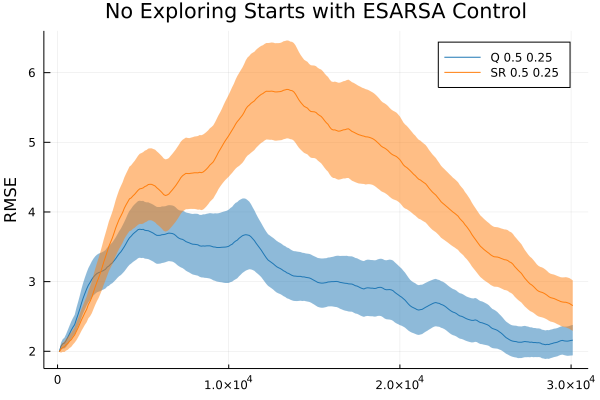

In [541]:
# labels = [GPU.get_label(algo, label_keys) for algo in best_per_algo_ics]
ylabel = "RMSE"
# title = "SR Demons & Step Size Adaptation vs More Naive Approaches"
title = "No Exploring Starts with ESARSA Control"
step_increment=100
num_samples = length(data[1])
xticks=collect(step_increment:step_increment:num_samples*step_increment)
num_runs = 20
plot(xticks, data, ylabel=ylabel, palette=:tab10, label= labels, grid=true, ribbon = std/sqrt(num_runs), legend=:topright, title=title)

In [542]:
savefig("./plots/experiment2/no_exploring_starts_esarsa_combined.png")

In [278]:
#Replicating plot from Experiment 1.
# inds_to_replicate = [1,3,4,8]
inds_to_replicate = [1,2,5,6]
label_subset = labels[:,inds_to_replicate]
data_subset = data[inds_to_replicate]
@show length(std)
label_subset

length(std) = 7


1×4 Array{String,2}:
 " GPI TB SR Auto TB 0.01 1.0 0.125 0.4"  …  " Q ESARSA SR Auto TB 1.0 0.5 0.25 0.4"

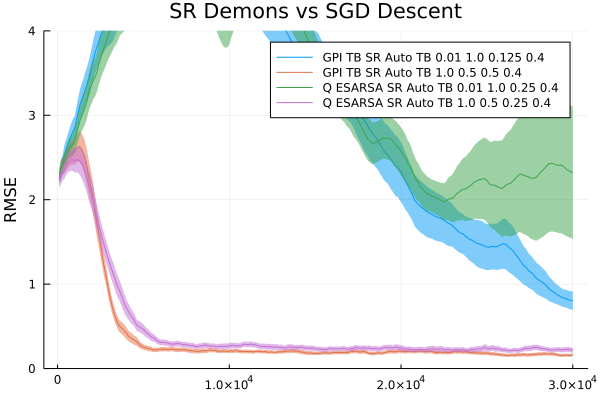

In [279]:
# title = "High vs Low Alpha Init"
title = "SR Demons vs SGD Descent"
ylabel = "RMSE"
step_increment=100
num_samples = length(data[1])
xticks=collect(step_increment:step_increment:num_samples*step_increment)
plot(xticks, data_subset,ylabel= ylabel, label= label_subset, ribbon = std[inds_to_replicate]/sqrt(30), legend=:topright, title=title, ylims=(0,4))

In [260]:
savefig("./plots/experiment2/high_vs_low_alpha_init.png")

In [234]:
inds_to_replicate = [5,6,7]
label_subset = labels[:,inds_to_replicate]
data_subset = data[inds_to_replicate]

4-element Array{Array{Float64,1},1}:
 [1.9181099487646451, 2.0293219787507892, 2.085500089730406, 2.1689908079448075, 2.2267692104209766, 2.2703040034826185, 2.321169368235307, 2.3694877705617365, 2.409609985125206, 2.4335928301580863  …  0.9202426225583491, 0.9094567620515683, 0.8949646678312002, 0.8838595427302247, 0.8768503837289027, 0.8714859484719932, 0.8610139435489085, 0.8538226379306533, 0.8480630649001251, 0.8428000492118735]
 [1.9537244996467416, 2.04516135675983, 2.0638841109262476, 2.088796053561995, 2.128620228840288, 2.1589135181746393, 2.191951729637584, 2.2189263973752857, 2.226499963947538, 2.2381940037899923  …  0.13975068060644436, 0.13572326379560615, 0.1339151639546532, 0.13258783439051863, 0.13557591606790742, 0.13610094537458237, 0.135439184595546, 0.13298289258891952, 0.1366094642283759, 0.13732975941501385]
 [1.9689353649783379, 2.0474267071912893, 2.072770850159802, 2.112071594340513, 2.156473418090883, 2.2077415614232145, 2.241628747920714, 2.2539388901783086

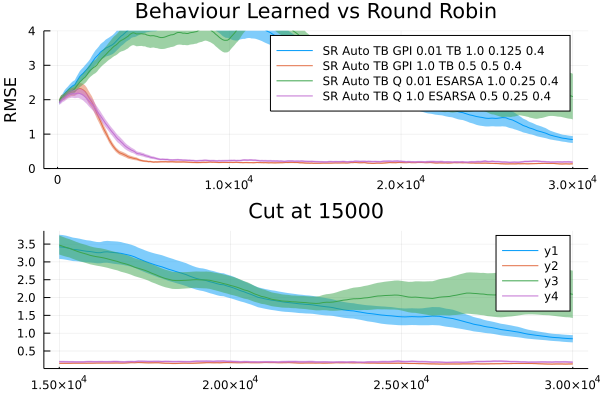

In [235]:
title = "Behaviour Learned vs Round Robin"
ylabel = "RMSE"
step_increment=100
num_samples = length(data[1])
xticks=collect(step_increment:step_increment:num_samples*step_increment)
p1 = plot(xticks, data_subset,ylabel= ylabel, label= label_subset, ribbon = std[inds_to_replicate]/sqrt(30), legend=:topright, title=title, ylims=(0,4))

start_pos = 150
new_x_ticks = collect(step_increment * start_pos:step_increment:num_samples*step_increment)
data_subset_cut = [s[start_pos:end] for s in data_subset]
std_subset_cut = [s[start_pos:end] for s in std[inds_to_replicate]/sqrt(30)]
p2 = plot(new_x_ticks,data_subset_cut, ribbon = std_subset_cut, title="Cut at $(step_increment * start_pos)")

plot(p1,p2, layout = (2,1), figsize=(20,20))


In [203]:
savefig("./plots/experiment2/learned_vs_round_robin.png")

In [559]:
episode_lengths = [GPU.load_results(ic,:episode_length, return_type = "array") for ic in best_per_algo_ics]
visit_orders = [GPU.load_results(ic,:visit_order, return_type = "array") for ic in best_per_algo_ics]

8-element Array{Array{Any,1},1}:
 [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 4, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 3, 3, 3, 3, 3, 4, 4], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 3, 4, 4, 3, 4, 3, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  2, 1, 1, 2, 2, 1, 1, 4, 2, 2], [3, 3, 3, 3, 3, 2, 3, 3, 3, 3  …  2, 2, 3, 3, 3, 3, 3, 3, 4, 4], [4, 4, 4, 4, 4, 4, 4, 4, 4, 4  …  3, 3, 3, 3, 3, 3, 4, 3, 4, 4], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 3, 3, 3, 3, 3, 2, 2], [1, 2, 4, 2, 2, 2, 1, 2, 2, 2  …  3, 3, 3, 3, 3, 3, 3, 3, 1, 2], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  4, 4, 3, 3, 3, 3, 3, 3, 4, 3], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 3, 3, 3, 3, 4, 4, 3], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  3, 3, 3, 3, 4, 3, 3, 3, 3, 3], [3, 3, 3, 3, 3, 3, 3, 3, 3, 3  …  3, 3, 3, 3, 3, 3, 3, 

In [561]:
length(visit_orders[1][7])
length(episode_lengths[1][7])

512

In [562]:
max_lengths = [GPU.get_min_length(arrs)-1 for arrs in episode_lengths]

8-element Array{Int64,1}:
 491
 270
 439
 411
 455
 354
 447
 352

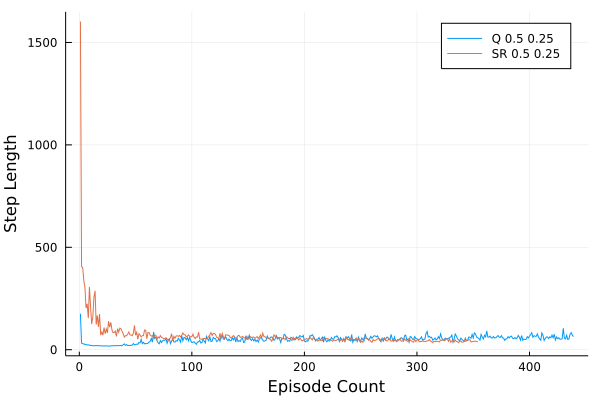

In [546]:
p = plot(xlabel = "Episode Count", ylabel = "Step Length")
for (ind,episode_lengths) in enumerate(episode_lengths)
    l = hcat([epi[1:max_lengths[ind]] for epi in episode_lengths]...)
    plot!(p,mean(l,dims=2), label = labels[ind])
end
# p = plot(mean(episode_lengths,dims=2), xlabel="Episode Count", ylabel="Step Length", hline=5.5)
display(p)
savefig("./plots/experiment2/no_exploring_starts_esarsa_combined_step_length.png")

In [452]:
# include("./plot_utils.jl")
# GPU = GeneralPlotUtils
gvf_labels = ["Distractor" "Constant" "Drifter" "Constant"]

1×4 Array{String,2}:
 "Distractor"  "Constant"  "Drifter"  "Constant"

size(visit_perc) = (4, 491)
size(visit_perc) = 

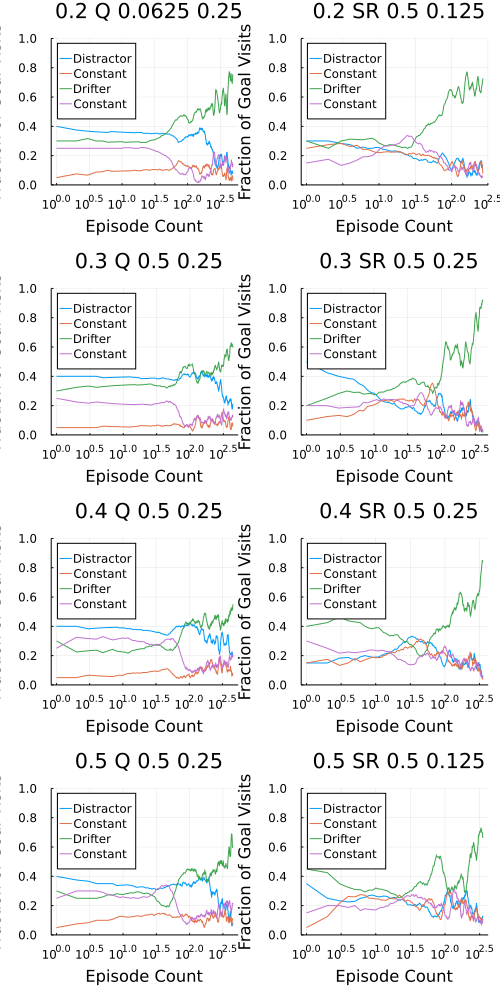

(4, 270)
size(visit_perc) = (4, 439)
size(visit_perc) = (4, 411)
size(visit_perc) = (4, 455)
size(visit_perc) = (4, 354)
size(visit_perc) = (4, 447)
size(visit_perc) = (4, 352)


In [563]:
ps = []
for i in 1:length(visit_orders)
    visit_perc = GPU.goal_visits_per_episode(visit_orders[i], max_lengths[i])
    @show size(visit_perc)
#     @show size(GPU.smooth(visit_perc, 5))
    smooth_visit_perc = GPU.smooth(visit_perc, 5)
    tmp = [GPU.smooth(visit_perc[i,:],20) for i in 1:4] 
    p = plot(tmp, labels = gvf_labels, xlabel="Episode Count", ylabel="Fraction of Goal Visits", ylim=(0.0,1.0), title = labels[i], xaxis=:log, size = (500,1000), legend=:topleft)
    push!(ps,p)
end
# plot(ps..., layout = (1,3))
# display(plot(ps...,layout = (2,1)))
# display(plot(ps...))
display(plot(ps..., layout=(4,2)))
savefig("./plots/experiment2/no_exploring_starts_esarsa_goal_visits.png")

In [549]:
num_gvfs = 4
ps = []
for i in 1:length(visit_orders)
    visitation = zeros(num_gvfs, num_gvfs)
    for run in 1:length(visit_orders[i])
        first_visit = visit_orders[i][run][1]
#         @show first_visit
        goals = unique(visit_orders[i][run])
#         @show goals
        visitation[first_visit,goals] .+= 1
    end
    @show maximum(visitation,dims=2)
    visitation = visitation ./ vec(maximum(visitation,dims=2))
    push!(ps, heatmap(visitation, title = labels[i], size = (1000,1300), c = :grayC))

end
plot(ps..., layout=(4,2))

maximum(visitation, dims = 2) = [32.0; 4.0; 24.0; 20.0]
maximum(visitation, dims = 2) = [25.0; 12.0; 24.0; 19.0]


LoadError: [91mWhen doing layout, n (8) != n_override (2).  You're probably trying to force existing plots into a layout that doesn't fit them.[39m

In [447]:
data_per_gvf = [GPU.get_stats(GPU.load_results(ic,data_key), per_gvf=true)[1] for ic in best_per_algo_ics]
std_per_gvf = [GPU.get_stats(GPU.load_results(ic,data_key), per_gvf=true)[2] for ic in best_per_algo_ics]

7-element Array{Array{Float64,2},1}:
 [0.0583830341159143 0.06624647800274217 … 0.025331506725205462 0.024397293962268633; 0.03889287145799879 0.03446226870970493 … 0.014794991119714154 0.01528194549588694; 0.3079138638493579 0.35845048085670994 … 0.9572012726441534 0.9556570344074108; 0.035480788145793404 0.031832843362199124 … 0.015620569934822087 0.01531906940544899]
 [0.05746913114522719 0.060282673279872516 … 0.06374158349618055 0.0663021718397726; 0.04238311595926881 0.04003501526891254 … 0.05524423798772834 0.05587831566970883; 0.3171130805123134 0.3811126732560389 … 0.5272433890472962 0.5564420792754703; 0.04308688359476702 0.04525075299928103 … 0.051676072712286886 0.0507582939644684]
 [0.08544790467545224 0.06717454621790661 … 0.08152217411938359 0.08263905464901689; 0.06831416291205408 0.04849036245726658 … 0.06357413347350213 0.06104375465736899; 0.27642337654811006 0.2944612366188357 … 0.44236477127168583 0.392611894224175; 0.05330815977525475 0.04235849230265052 … 0.06063

In [382]:
GPU.get_stats(GPU.load_results(best_per_algo_ics[1],data_key), per_gvf=true)[2]

4×40 Array{Float64,2}:
 0.058383   0.0662465  0.0679944  …  0.0257236  0.0253315  0.0243973
 0.0388929  0.0344623  0.0264279     0.0146811  0.014795   0.0152819
 0.307914   0.35845    0.380958      0.934579   0.957201   0.955657
 0.0354808  0.0318328  0.0251053     0.016249   0.0156206  0.0153191

In [420]:
data[1] .== data[3]

4×40 BitArray{2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

In [446]:
inds_to_replicate

4-element Array{Int64,1}:
 1
 2
 3
 6

In [451]:
ps = []
for ind in inds_to_replicate
    label_subset = labels[:,ind]
    data_subset = data_per_gvf[ind]
    std_subset = std_per_gvf[ind]
    @show size(std_subset)
    xticks=collect(step_increment:step_increment:num_samples*step_increment)
    p = plot(xticks,data_subset',label= ["Distractor" "Const" "Drifter" "Const"], ribbon = (std_subset/sqrt(100))', legend=:bottomleft, title=labels[ind], ylims=(0,1.25))
    push!(ps,p)
end

size(std_subset) = (4, 40)
size(std_subset) = (4, 40)
size(std_subset) = (4, 40)
size(std_subset) = (4, 40)


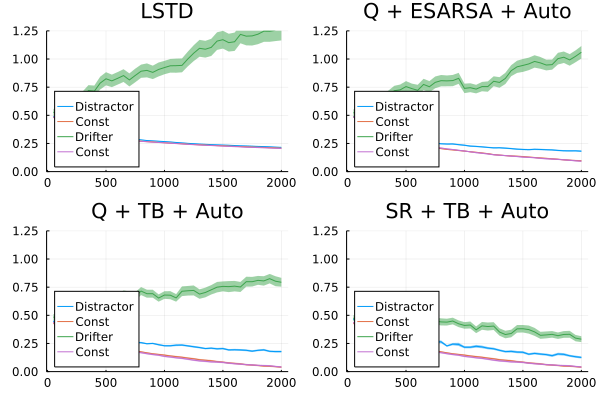

In [452]:
plot(ps..., layout=(2,2))

In [453]:
savefig("./plots/TabTMazeRoundRobin_per_gvf.png")